In [3]:
###########IMPORT DATA ##########

import os
import numpy as np 
import nibabel
import requests
import zipfile
import pandas as pd
import nibabel
import matplotlib.pyplot as plt


####This is an example of how we can scrape data from internet once we decide at we want
# Define the URL of the data and download 
url = 'http://www.fil.ion.ucl.ac.uk/spm/download/data/MoAEpilot/MoAEpilot.zip'
data = requests.get(url)

# Check if the targed folder for storing the data already exists. If not create it and save the zip file.
if os.path.exists('./fMRI_data') == False:
    os.mkdir('fMRI_data')
    
open('./fMRI_data/data.zip', 'wb').write(data.content)

# Un-zip the file
zip_ref = zipfile.ZipFile('./fMRI_data/data.zip', 'r')
zip_ref.extractall('./fMRI_data/')
zip_ref.close()

#we will need to know how many time points our data has to fill in these parameters!!!!
x_size = 64
y_size = 64
n_slice = 64
n_volumes = 96

block_design    = ['rest', 'stim']
block_size      = 6
block_RT        = 7
block_total     = 16
block_length    = block_size*block_RT
print block_length
acq_num         = block_size*block_total
data_time       = block_length*block_total
data_time_vol   = np.arange(acq_num)*block_RT
x_size = 64
y_size = 64


data_path = './fMRI_data/fM00223/'
files = os.listdir(data_path)

data_all = []
for data_file in files:
    if data_file[-3:] == 'hdr':
        data = nibabel.load(data_path + data_file).get_data()   
        data_all.append(data.reshape(x_size, y_size, n_slice))

print data.shape

# Rearrange and reshape data for export
data_all = np.transpose(data_all, [3, 2, 1, 0])
data_all = np.reshape(data_all, [n_slice, y_size*x_size, n_volumes])

# Check if output path exists, if not create it.
if os.path.exists('./fMRI_data/csv_data') == False:
    os.mkdir('./fMRI_data/csv_data')

# Export each slice as a .csv file 
n = 0
for export in data_all:

    save_file = 'slice_{}.csv'.format(n)
    save_path = './fMRI_data/csv_data/{}'.format(save_file)
    pd.DataFrame(export).to_csv(save_path, header=False, index=False)
    n += 1
    
data = np.genfromtxt('./fMRI_data/csv_data/slice_36.csv',delimiter=',')
# Reshape the data to 2 spatial and 1 temporal dimensions
data_ordered = data.reshape(x_size, y_size, acq_num)

print data_all.shape

42
(64, 64, 64, 1)
(64, 4096, 96)


In [4]:
#######DEFINE PARAMETERS FOR DATA ############
block_design    = ['rest', 'stim']
block_size      = 6
block_RT        = 7
block_total     = 16
block_length    = block_size*block_RT
print block_length
acq_num         = block_size*block_total
data_time       = block_length*block_total
data_time_vol   = np.arange(acq_num)*block_RT
x_size = 64
y_size = 64

# Reshape the data
data_ordered = data.reshape(x_size, y_size, acq_num)

# Calculate the mean signal for each voxel
mean_data = data_ordered.mean(axis=2)
print data_time



42
672


In [5]:
#make constant col in design MATRIX 
constant = np.ones(acq_num)
print constant.shape

(96,)


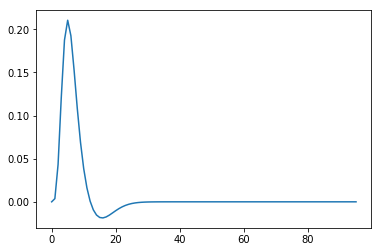

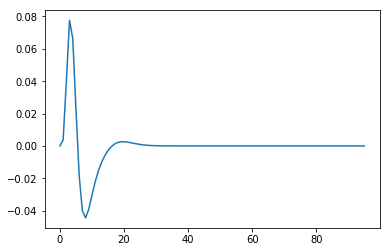

In [6]:
from scipy.stats import t as t_dist, f as f_dist, gamma
def spm_hrf(t):
    """ Return SPM hrf sampled at times `t`
    """
    # gamma.pdf only defined for t > 0
    hrf = np.zeros_like(t, dtype=np.float)
    hrf[t > 0] = gamma.pdf(t[t > 0], 6, 0, 1) - gamma.pdf(t[t > 0], 16, 0, 1) / 6.
    return hrf / np.sum(hrf)

def spm_hrf_d(t):
    """ Return temporal derivative of SPM HRF sampled at times `t`
    """
    # This is what spm does!
    return spm_hrf(t) - spm_hrf(t - 1)

#plotting to see if this is actually doing what we want 
t = np.arange(96)
plt.plot(t, spm_hrf(t), label='HRF')
plt.show()
plt.plot(t, spm_hrf_d(t), label='TD')
plt.show()

(96,)


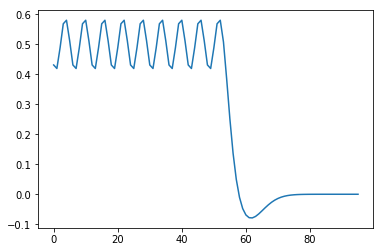

(96,)


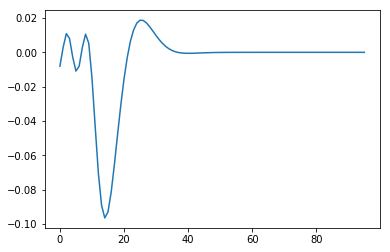

(96,)


In [7]:
############### MODIFY DESIGN MATRIX ########
###add our time derivative here 

block_length = 3 #this is the block TIME - discrepancy from combining code from diff people's scripts
on_off = np.hstack((np.zeros(block_length), np.ones(block_length)))
off_on = 1 - on_off
X_hrf_over = np.column_stack((on_off, off_on, np.ones_like(on_off)))
X_hrf_over = np.tile(X_hrf_over, (16, 1))

#Make HRF
hrf = spm_hrf(t)
x0 = np.convolve(hrf, X_hrf_over[:, 0], mode='same')
x1 = np.convolve(hrf, X_hrf_over[:, 1], mode='same')
X_conv_over = np.column_stack((x0, x1, np.ones_like(x0)))
x0_hrf = X_conv_over[:, 0]
print x0_hrf.shape
ton = np.arange(96)
#ton = np.arange(192)
plt.plot(ton, x0_hrf, label='TD')
plt.show()


#Make a temporal derivative:
#dhrf = spm_hrf_d(np.arange(672))
dhrf = spm_hrf_d(t)
#dhrf = spm_hrf_d(np.arange(192))
x0_dhrf = np.convolve(dhrf, x0, mode='same')
print x0_dhrf.shape
plt.plot(ton, x0_dhrf, label='TD')
plt.show()



design_matrix = np.array((constant, x0_hrf))
design_matrix_2 = np.array((constant, x0_hrf, x0_dhrf))
print design_matrix[1].shape

In [8]:

def do_GLM(X, y):
# Make sure the design matrix has the right orientation
    if X.shape[1] > X.shape[0]:
        X = X.transpose()
    
# Calculate the dot product of the transposed design matrix 
# and the design matrix and invert the resulting matrix.
    tmp   = np.linalg.inv(X.transpose().dot(X))
# Now calculate the dot product of the above result and the 
# transposed design matrix
    tmp   = tmp.dot(X.transpose())
# Pre-allocate variables
    beta  = np.zeros((y.shape[0], X.shape[1]))
    e     = np.zeros(y.shape)
    model = np.zeros(y.shape)
    r     = np.zeros(y.shape[0])
    
# Find the beta values, the error and the correlation coefficients 
# between the model and the data for each voxel in the data.
    for i in range(y.shape[0]):
        beta[i]  = tmp.dot(y[i,:].transpose())
        model[i] = X.dot(beta[i])
        e[i]     = (y[i,:] - model[i])
        r[i]     = np.sqrt(model[i].var()/y[i,:].var())
    
    return beta, model, e, r

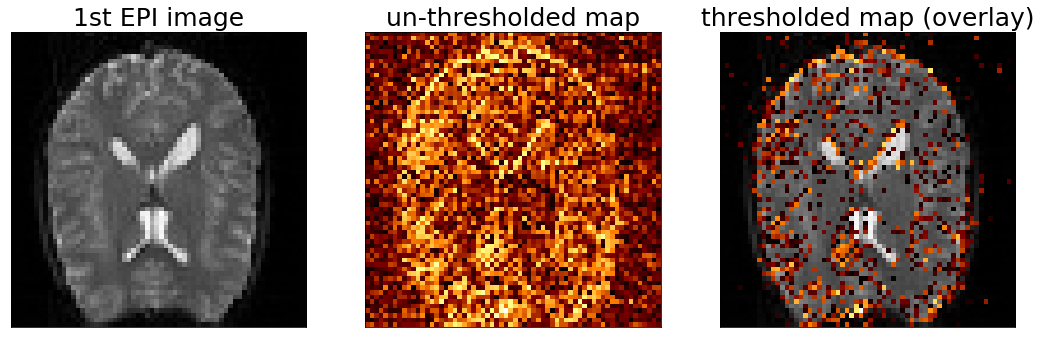

In [9]:
# Run the GLM
beta, model, e, r = do_GLM(design_matrix_2, data)
# Reshape the correlation vector r to create a map
r = r.reshape(x_size,y_size)
map = r.copy()
map[map<0.3] = np.nan

# Plot the result
fig, ax = plt.subplots(1,3,figsize=(18, 6))
ax[0].imshow(mean_data, cmap='gray')
ax[0].set_title('1st EPI image', fontsize=25)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].imshow(r, cmap='afmhot')
ax[1].set_title('un-thresholded map', fontsize=25)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].imshow(mean_data, cmap='gray')
ax[2].imshow(map, cmap='afmhot')
ax[2].set_title('thresholded map (overlay)', fontsize=25)
ax[2].set_xticks([])
ax[2].set_yticks([])
plt.show()

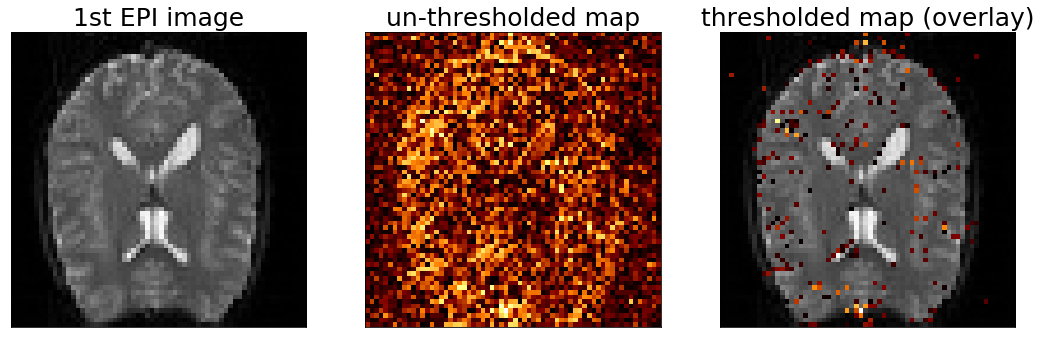

In [10]:
# Run the GLM
beta, model, e, r = do_GLM(design_matrix, data)
# Reshape the correlation vector r to create a map
r = r.reshape(x_size,y_size)
map = r.copy()
map[map<0.3] = np.nan

# Plot the result
fig, ax = plt.subplots(1,3,figsize=(18, 6))
ax[0].imshow(mean_data, cmap='gray')
ax[0].set_title('1st EPI image', fontsize=25)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].imshow(r, cmap='afmhot')
ax[1].set_title('un-thresholded map', fontsize=25)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].imshow(mean_data, cmap='gray')
ax[2].imshow(map, cmap='afmhot')
ax[2].set_title('thresholded map (overlay)', fontsize=25)
ax[2].set_xticks([])
ax[2].set_yticks([])
plt.show()